In [6]:
# -*- coding: utf-8 -*-
# fmt: off



# **Implementação do Projeto End-to-end do Capítulo 2 (Hands-On ML)**
#
## *Este script segue o projeto do capítulo 2 do livro "Hands-On Machine Learning",*
## *focando na previsão de preços de casas na Califórnia.*
## *A principal adaptação é usar PyTorch para a modelagem.*

### Lucas Lima Neves - 201905463

In [7]:
print("Iniciando o projeto de Machine Learning!")

Iniciando o projeto de Machine Learning!


Verificando a versão do Python (precisa ser 3.7+)

In [8]:
import sys
import platform

In [9]:
print(f"Versão do Python: {platform.python_version()}")
assert sys.version_info >= (3, 7)

Versão do Python: 3.12.4


Verificando a versão do Scikit-Learn (precisa ser ≥ 1.0.1)

In [10]:
%pip install packaging scikit-learn torch pandas numpy matplotlib


  Using cached scikit_learn-1.6.1-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (18 kB)
  Using cached torch-2.6.0-cp312-cp312-manylinux1_x86_64.whl.metadata (28 kB)
  Using cached pandas-2.2.3-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (89 kB)
  Using cached numpy-2.2.4-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached scipy-1.15.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
  Using cached filelock-3.18.0-py3-none-any.whl.metadata (2.9 kB)
  Using cached typing_extensions-4.13.2-py3-none-any.whl.metadata (3.0 kB)
  Using cached networkx-3.4.2-py3-none-any.whl.metadata (6.3 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
  Using cached nvidia_cuda_nvrtc_cu

In [11]:
from packaging import version
import sklearn
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tarfile
import urllib.request
from pathlib import Path
from zlib import crc32
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim

In [12]:
print(f"Versão Scikit-Learn: {sklearn.__version__}")
assert version.parse(sklearn.__version__) >= version.parse("1.0.1")
print(f"Versão PyTorch: {torch.__version__}")
print(f"Versão Pandas: {pd.__version__}")
print(f"Versão NumPy: {np.__version__}")

Versão Scikit-Learn: 1.6.1
Versão PyTorch: 2.6.0+cu124
Versão Pandas: 2.2.3
Versão NumPy: 2.2.4


# Obtendo os Dados<br>
*A tarefa aqui é prever os valores medianos das casas nos distritos da Califórnia.*

## Download dos Dados

In [13]:
def load_housing_data():
    """Função para baixar e carregar os dados de habitação da Califórnia."""
    tarball_path = Path("datasets/housing.tgz")
    if not tarball_path.is_file():
        Path("datasets").mkdir(parents=True, exist_ok=True)
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        print(f"Baixando dados de {url} para {tarball_path}")
        urllib.request.urlretrieve(url, tarball_path)
        print("Download completo.")
    print(f"Extraindo dados de {tarball_path}")
    with tarfile.open(tarball_path) as housing_tarball:
        housing_tarball.extractall(path="datasets")
    print("Extração completa.")
    csv_path = Path("datasets/housing/housing.csv")
    print(f"Carregando dados de {csv_path}")
    return pd.read_csv(csv_path)

In [14]:
housing = load_housing_data()
print("Dados carregados com sucesso.")

Extraindo dados de datasets/housing.tgz
Extração completa.
Carregando dados de datasets/housing/housing.csv
Dados carregados com sucesso.


/tmp/ipykernel_4891/2588328529.py:12: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  housing_tarball.extractall(path="datasets")


## Explorando a Estrutura dos Dados

Verificando as primeiras linhas

In [15]:
print("\n--- Primeiras 5 linhas dos dados ---")
print(housing.head())


--- Primeiras 5 linhas dos dados ---
   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY  


Obtendo informações gerais do DataFrame

In [16]:
print("\n--- Informações do DataFrame ---")
housing.info()


--- Informações do DataFrame ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


Verificando a distribuição da coluna categórica 'ocean_proximity'

In [17]:
print("\n--- Contagem de valores para 'ocean_proximity' ---")
print(housing["ocean_proximity"].value_counts())


--- Contagem de valores para 'ocean_proximity' ---
ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64


Obtendo estatísticas descritivas das colunas numéricas

In [18]:
print("\n--- Estatísticas descritivas dos dados ---")
print(housing.describe())


--- Estatísticas descritivas dos dados ---
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.0

Código extra do livro para salvar figuras (útil manter caso necessário)

In [19]:
IMAGES_PATH = Path() / "images" / "end_to_end_project"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

In [20]:
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    """Salva a figura atual em um arquivo."""
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    print(f"Salvando figura {fig_id}")
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

Configurando Matplotlib como sugerido

In [21]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

Gerando histogramas para visualizar as distribuições dos atributos


--- Gerando histogramas dos atributos ---
Salvando figura attribute_histogram_plots


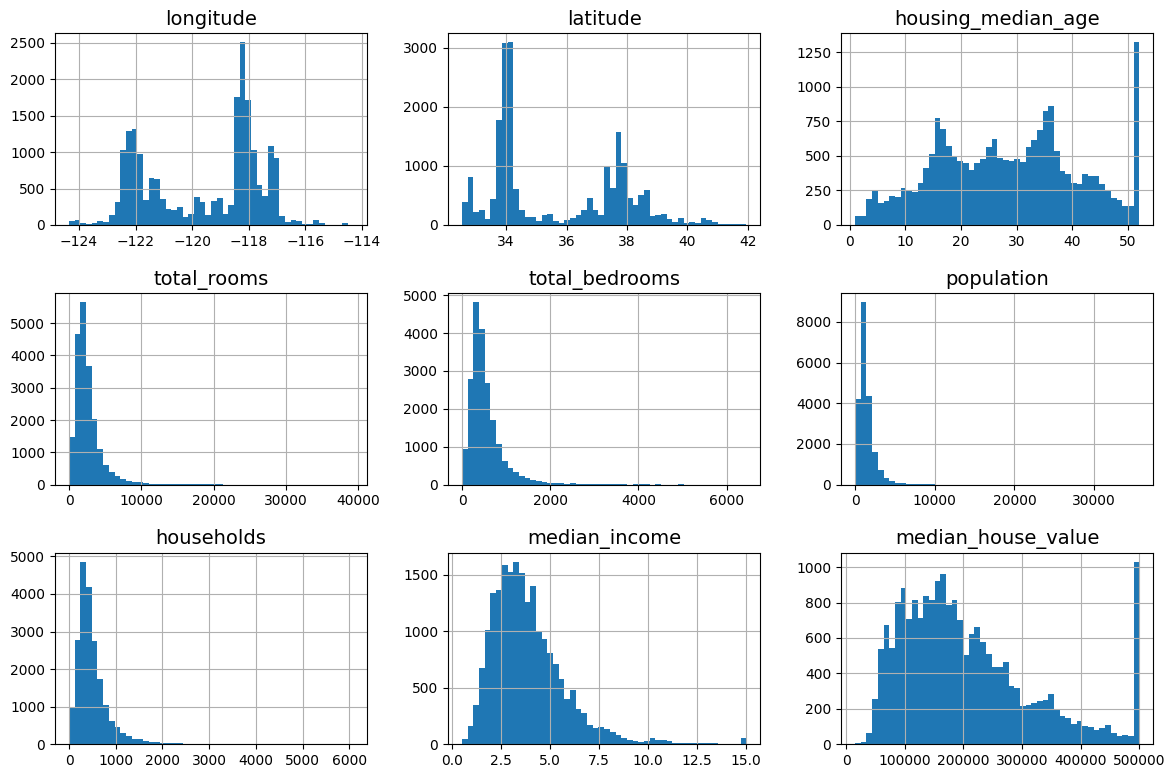

Histogramas gerados.


In [22]:
print("\n--- Gerando histogramas dos atributos ---")
housing.hist(bins=50, figsize=(12, 8))
save_fig("attribute_histogram_plots")
plt.show()
print("Histogramas gerados.")

## Criando um Conjunto de Teste<br>
<br>
Vou usar divisão estratificada baseada na renda mediana, como recomendado,<br>
para garantir que o teste seja representativo.

Primeiro, criar categorias de renda para a estratificação

In [23]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

Visualizando a distribuição das categorias de renda


--- Distribuição das categorias de renda (para estratificação) ---
Salvando figura housing_income_cat_bar_plot


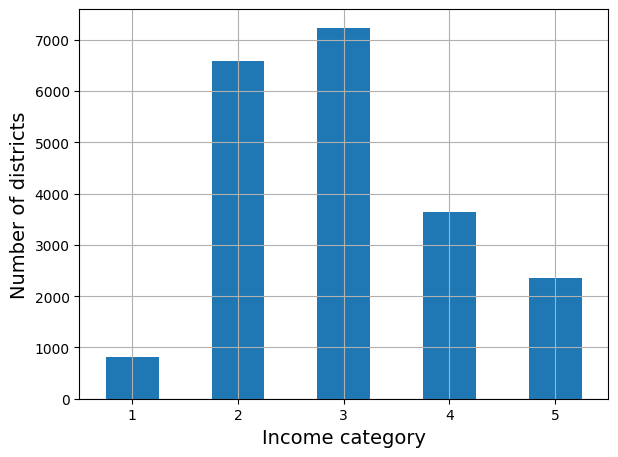

In [24]:
print("\n--- Distribuição das categorias de renda (para estratificação) ---")
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
save_fig("housing_income_cat_bar_plot")
plt.show()

Realizando a divisão estratificada

In [25]:
print("\n--- Dividindo os dados em treino e teste (estratificado) ---")
strat_train_set, strat_test_set = train_test_split(
    housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)


--- Dividindo os dados em treino e teste (estratificado) ---


Removendo a coluna auxiliar 'income_cat' dos conjuntos

In [26]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [27]:
print(f"Tamanho do conjunto de treino: {len(strat_train_set)}")
print(f"Tamanho do conjunto de teste: {len(strat_test_set)}")

Tamanho do conjunto de treino: 16512
Tamanho do conjunto de teste: 4128


## Descobrindo e Visualizando os Dados para Obter Insights

Criando uma cópia do conjunto de treino para não mexer no original durante a exploração

In [69]:
housing = strat_train_set.copy()

## Visualizando Dados Geográficos

Plot simples de longitude vs latitude para ver a densidade


--- Visualizando dados geográficos (densidade populacional) ---
Salvando figura bad_visualization_plot


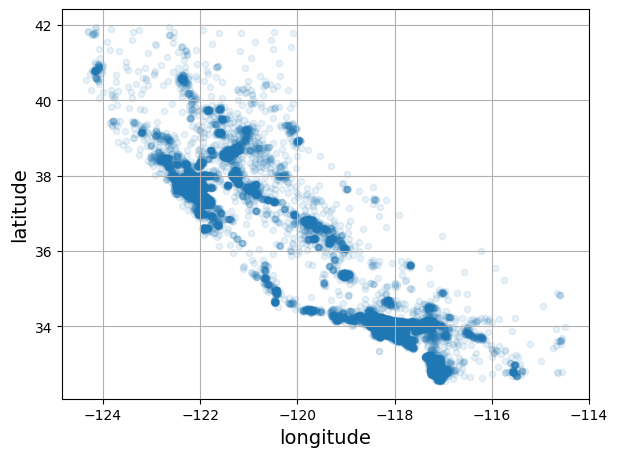

In [29]:
print("\n--- Visualizando dados geográficos (densidade populacional) ---")
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True, alpha=0.1)
save_fig("bad_visualization_plot")
plt.show()

Plot mais informativo: localização, população (tamanho) e preço mediano (cor)


--- Visualizando dados geográficos (preço mediano e população) ---
Salvando figura housing_prices_scatterplot


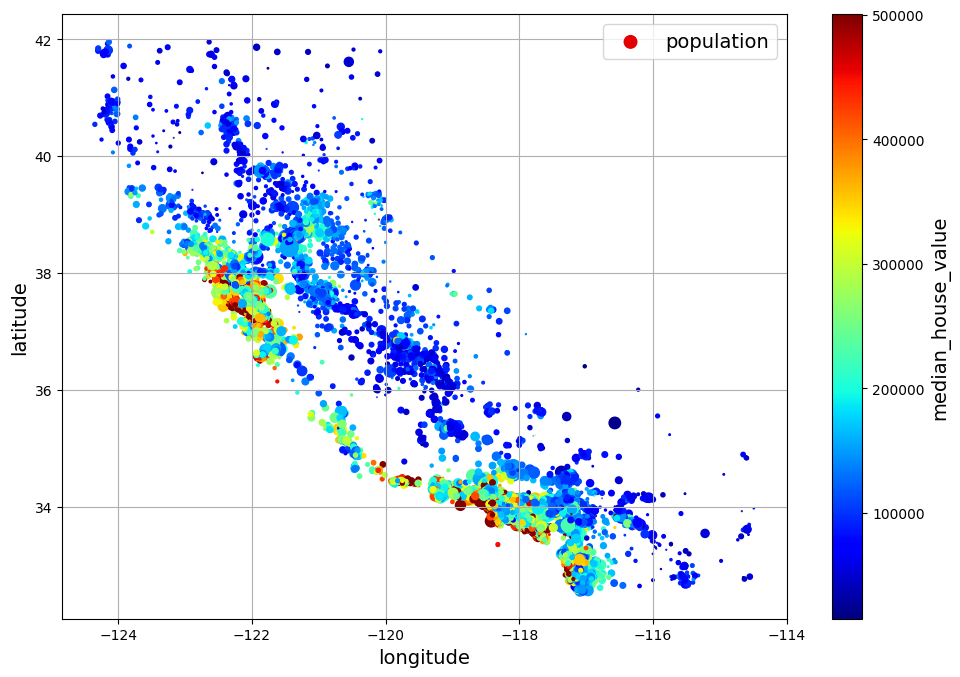

Visualizações geográficas geradas.


In [30]:
print("\n--- Visualizando dados geográficos (preço mediano e população) ---")
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, sharex=False, figsize=(10, 7))
save_fig("housing_prices_scatterplot")
plt.show()
print("Visualizações geográficas geradas.")

## Procurando por Correlações

Calculando a matriz de correlação padrão

In [31]:
print("\n--- Calculando matriz de correlação ---")
corr_matrix = housing.corr(numeric_only=True) # Usando numeric_only=True para evitar warnings futuros


--- Calculando matriz de correlação ---


Vendo as correlações com o valor mediano da casa

In [32]:
print("\n--- Correlação com 'median_house_value' ---")
print(corr_matrix["median_house_value"].sort_values(ascending=False))


--- Correlação com 'median_house_value' ---
median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64


Scatter matrix 


--- Gerando scatter matrix (pode demorar) ---
Salvando figura scatter_matrix_plot


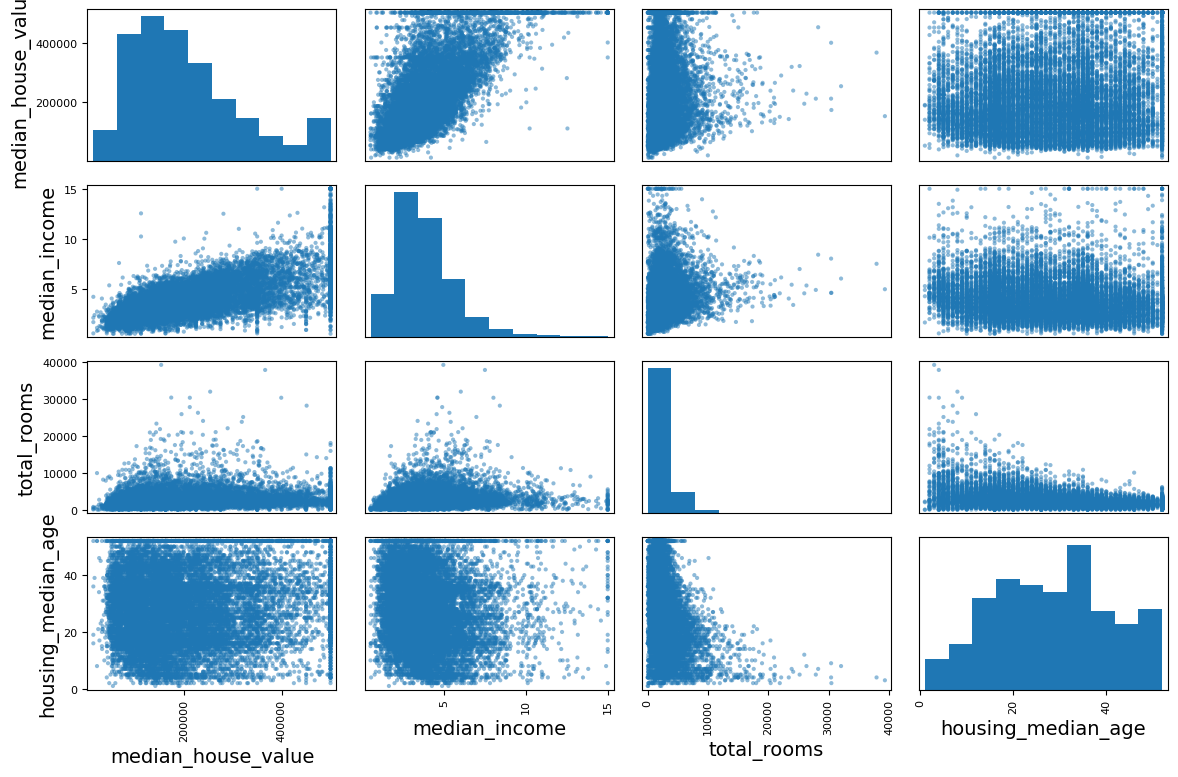

In [70]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]
print("\n--- Gerando scatter matrix (pode demorar) ---")
scatter_matrix(housing[attributes], figsize=(12, 8))
save_fig("scatter_matrix_plot")
plt.show()
#longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity

Focando na correlação mais promissora: renda mediana vs valor da casa


--- Scatter plot: median_income vs median_house_value ---
Salvando figura income_vs_house_value_scatterplot


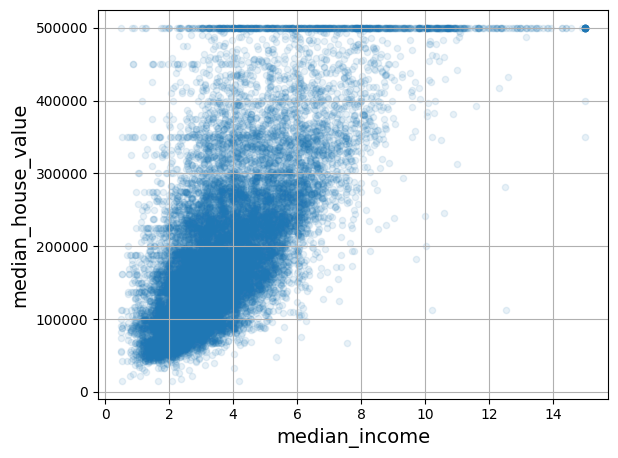

Plots de correlação gerados.


In [33]:
print("\n--- Scatter plot: median_income vs median_house_value ---")
housing.plot(kind="scatter", x="median_income", y="median_house_value",
             alpha=0.1, grid=True)
save_fig("income_vs_house_value_scatterplot")
plt.show()
print("Plots de correlação gerados.")

## Experimentando com Combinações de Atributos

Criando novas features como sugerido no livro

In [34]:
print("\n--- Criando atributos combinados ---")
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]


--- Criando atributos combinados ---


Recalculando as correlações para ver o impacto das novas features

In [35]:
corr_matrix = housing.corr(numeric_only=True) # Usando numeric_only=True
print("\n--- Correlação com 'median_house_value' (após combinações) ---")
print(corr_matrix["median_house_value"].sort_values(ascending=False))
print("Atributos combinados criados e correlações recalculadas.")


--- Correlação com 'median_house_value' (após combinações) ---
median_house_value          1.000000
median_income               0.688380
rooms_per_household         0.143663
total_rooms                 0.137455
housing_median_age          0.102175
households                  0.071426
total_bedrooms              0.054635
population                 -0.020153
population_per_household   -0.038224
longitude                  -0.050859
latitude                   -0.139584
bedrooms_per_room          -0.256397
Name: median_house_value, dtype: float64
Atributos combinados criados e correlações recalculadas.


# Preparando os Dados para os Algoritmos de Machine Learning

Separando as features (preditores) e os labels (valor mediano da casa)

In [36]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()

## Limpeza dos Dados (Tratando Valores Ausentes)

Verificando a coluna 'total_bedrooms' que tem valores ausentes

In [37]:
print("\n--- Tratando valores ausentes (estratégia: SimpleImputer no pipeline) ---")
# Opções mencionadas no livro (comentadas porque farei no pipeline):
# Opção 1: Remover distritos com valores ausentes
# housing.dropna(subset=["total_bedrooms"], inplace=True)
# Opção 2: Remover o atributo
# housing.drop("total_bedrooms", axis=1, inplace=True)
# Opção 3: Preencher com a mediana
# median = housing["total_bedrooms"].median()
# housing["total_bedrooms"].fillna(median, inplace=True)
# Decidi usar o SimpleImputer no pipeline para tratar isso sistematicamente.
print("Estratégia de tratamento de valores ausentes definida.")


--- Tratando valores ausentes (estratégia: SimpleImputer no pipeline) ---
Estratégia de tratamento de valores ausentes definida.


## Tratando Atributos de Texto e Categóricos

Separando as colunas numéricas das categóricas

In [38]:
print("\n--- Separando atributos numéricos e categóricos ---")
housing_num = housing.select_dtypes(include=[np.number])
housing_cat = housing[["ocean_proximity"]] # Mantendo como DataFrame


--- Separando atributos numéricos e categóricos ---


In [39]:
print(f"Atributos numéricos: {list(housing_num.columns)}")
print(f"Atributos categóricos: {list(housing_cat.columns)}")

Atributos numéricos: ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']
Atributos categóricos: ['ocean_proximity']


Será utilizado o OneHotEncoder no pipeline para a coluna 'ocean_proximity'.<br>
Exemplo de como seria:<br>
print("\n--- Exemplo de One-Hot Encoding ---")<br>
cat_encoder = OneHotEncoder(sparse_output=False)<br>
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)<br>
print(housing_cat_1hot[:5])<br>
print(f"Categorias encontradas: {cat_encoder.categories_}")

In [40]:
print("Estratégia de tratamento de atributos categóricos definida (OneHotEncoder no pipeline).")

Estratégia de tratamento de atributos categóricos definida (OneHotEncoder no pipeline).


## Pipelines de Escalonamento de Features e Transformação

Criando transformadores para adicionar as features combinadas dentro do pipeline<br>
Preciso dos índices das colunas originais

Função para adicionar as features extras (usando FunctionTransformer)

In [41]:
rooms_ix, bedrooms_ix, population_ix, households_ix = [
    list(housing.columns).index(col)
    for col in ("total_rooms", "total_bedrooms", "population", "households")]

In [42]:
def add_extra_features(X):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]
    # Adiciona bedrooms_per_room, tratando divisão por zero e possíveis NaNs (imputer cuida disso)
    bedrooms_per_room = np.zeros_like(X[:, rooms_ix])
    mask = X[:, rooms_ix] != 0
    bedrooms_per_room[mask] = X[mask, bedrooms_ix] / X[mask, rooms_ix]
    return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]

In [43]:
attr_adder = FunctionTransformer(add_extra_features, validate=False)

Definindo o pipeline para os atributos numéricos

In [44]:
print("\n--- Definindo pipeline de pré-processamento numérico ---")
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # Preenche NaNs
    ('attribs_adder', attr_adder),              # Adiciona features combinadas
    ('std_scaler', StandardScaler()),           # Padroniza
])


--- Definindo pipeline de pré-processamento numérico ---


Definindo o pipeline completo para todos os atributos (numéricos e categóricos)

In [45]:
print("\n--- Definindo pipeline de pré-processamento completo ---")
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]


--- Definindo pipeline de pré-processamento completo ---


In [46]:
full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),      # Aplica o pipeline numérico
    ("cat", OneHotEncoder(handle_unknown='ignore'), cat_attribs), # Aplica OneHotEncoder no categórico
])

Aplicando o pipeline completo aos dados de treino

In [47]:
print("\n--- Aplicando pipeline aos dados de treino ---")
housing_prepared = full_pipeline.fit_transform(housing)
print(f"Shape dos dados preparados: {housing_prepared.shape}")
print("Pré-processamento dos dados de treino concluído.")


--- Aplicando pipeline aos dados de treino ---
Shape dos dados preparados: (16512, 16)
Pré-processamento dos dados de treino concluído.


Tentando obter os nomes das features após o pipeline (útil para entender a saída)

In [48]:
try:
    num_features_added = ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']
    cat_one_hot_features = list(full_pipeline.named_transformers_['cat'].get_feature_names_out(cat_attribs))
    feature_names = num_attribs + num_features_added + cat_one_hot_features
    print(f"\nTotal de features após pré-processamento: {len(feature_names)}")
    #print(f"Nomes das features: {feature_names}") # Descomentar se quiser ver a lista longa
except Exception as e:
    print(f"Não foi possível obter nomes das features: {e}")
    feature_names = None


Total de features após pré-processamento: 16


# Selecionando e Treinando um Modelo (Adaptação com PyTorch)<br>
<br>
Nesta parte, o projeto será adaptado para usar uma rede neural simples (MLP) com PyTorch.

1. Preparando os Dados para PyTorch (convertendo para tensores)

In [49]:
print("\n--- Preparando dados para PyTorch ---")
X_train_tensor = torch.tensor(housing_prepared, dtype=torch.float32)
y_train_tensor = torch.tensor(housing_labels.values, dtype=torch.float32).unsqueeze(1) # Precisa de dimensão extra


--- Preparando dados para PyTorch ---


Aplicando o mesmo pipeline aos dados de teste (importante: usar só transform!)

In [50]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()
X_test_prepared = full_pipeline.transform(X_test)
X_test_tensor = torch.tensor(X_test_prepared, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

2. Definindo o Dataset e DataLoader do PyTorch

In [51]:
class HousingDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [52]:
batch_size = 64 # Definindo tamanho do batch
train_dataset = HousingDataset(X_train_tensor, y_train_tensor)
test_dataset = HousingDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Datasets e DataLoaders criados.")

Datasets e DataLoaders criados.


3. Definindo o Modelo (Rede Neural MLP)

In [53]:
class HousingMLP(nn.Module):
    def __init__(self, input_size, hidden_size1=256, hidden_size2=128, hidden_size3=64, hidden_size4=32):
        super(HousingMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()
        self.layer3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.layer4 = nn.Linear(hidden_size3, hidden_size4)  
        self.relu4 = nn.ReLU()                        
        self.output_layer = nn.Linear(hidden_size4, 1) # Camada de saída ajustada
    def forward(self, x):
        x = self.relu1(self.layer1(x))
        x = self.relu2(self.layer2(x))
        x = self.relu3(self.layer3(x))
        x = self.relu4(self.layer4(x)) 
        x = self.output_layer(x)
        return x

In [54]:
input_size = X_train_tensor.shape[1] # Tamanho da entrada baseado nos dados preparados
model = HousingMLP(input_size)
print("\n--- Arquitetura do Modelo MLP Definida ---")
print(model)


--- Arquitetura do Modelo MLP Definida ---
HousingMLP(
  (layer1): Linear(in_features=16, out_features=256, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (layer4): Linear(in_features=64, out_features=32, bias=True)
  (relu4): ReLU()
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)


4. Definindo a Função de Perda e o Otimizador

In [55]:
criterion = nn.MSELoss() # Erro Quadrático Médio para regressão
optimizer = optim.Adam(model.parameters(), lr=0.001) # Otimizador Adam
print("Função de perda (MSE) e otimizador (Adam) definidos.")

Função de perda (MSE) e otimizador (Adam) definidos.


5. Treinando o Modelo

In [56]:
print("\n--- Iniciando treinamento do modelo PyTorch ---")
num_epochs = 250 # Aumentado de 100 para 250
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Usa GPU se disponível
print(f"Usando dispositivo: {device}")
model.to(device) # Mover modelo para o dispositivo


--- Iniciando treinamento do modelo PyTorch ---
Usando dispositivo: cuda


HousingMLP(
  (layer1): Linear(in_features=16, out_features=256, bias=True)
  (relu1): ReLU()
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (relu2): ReLU()
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (relu3): ReLU()
  (layer4): Linear(in_features=64, out_features=32, bias=True)
  (relu4): ReLU()
  (output_layer): Linear(in_features=32, out_features=1, bias=True)
)

In [57]:
train_losses = [] # Para guardar o histórico de perdas
for epoch in range(num_epochs):
    model.train() # Colocar modelo em modo de treinamento
    running_loss = 0.0
    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device), labels.to(device) # Mover dados para o dispositivo

        # Forward pass: calcular saídas do modelo
        outputs = model(features)
        loss = criterion(outputs, labels) # Calcular a perda

        # Backward pass e otimização
        optimizer.zero_grad() # Zerar gradientes
        loss.backward() # Calcular gradientes
        optimizer.step() # Atualizar pesos
        running_loss += loss.item() * features.size(0) # Acumular perda (ajustada pelo batch size)
    epoch_loss = running_loss / len(train_loader.dataset) # Calcular perda média da época
    train_losses.append(epoch_loss)
    if (epoch + 1) % 10 == 0: # Printar progresso a cada 10 épocas
        print(f'Época [{epoch+1}/{num_epochs}], Perda (MSE): {epoch_loss:.4f}')

Época [10/250], Perda (MSE): 4023731721.9225
Época [20/250], Perda (MSE): 3795752490.6667
Época [30/250], Perda (MSE): 3614202684.0310
Época [40/250], Perda (MSE): 3446716137.1783
Época [50/250], Perda (MSE): 3275894372.7132
Época [60/250], Perda (MSE): 3113357180.5271
Época [70/250], Perda (MSE): 2998701213.7674
Época [80/250], Perda (MSE): 2895144668.0310
Época [90/250], Perda (MSE): 2797399335.6899
Época [100/250], Perda (MSE): 2693260401.6124
Época [110/250], Perda (MSE): 2633090154.4186
Época [120/250], Perda (MSE): 2574310855.9380
Época [130/250], Perda (MSE): 2526398755.4729
Época [140/250], Perda (MSE): 2489136711.1938
Época [150/250], Perda (MSE): 2449693195.4109
Época [160/250], Perda (MSE): 2434561625.3023
Época [170/250], Perda (MSE): 2378705186.9767
Época [180/250], Perda (MSE): 2365184177.3643
Época [190/250], Perda (MSE): 2322694429.0233
Época [200/250], Perda (MSE): 2304543915.6589
Época [210/250], Perda (MSE): 2293485767.1938
Época [220/250], Perda (MSE): 2266481980.27

In [58]:
print("Treinamento concluído.")

Treinamento concluído.


Plotando a curva de aprendizado (MSE loss vs Época)

Salvando figura pytorch_training_mse_loss_curve


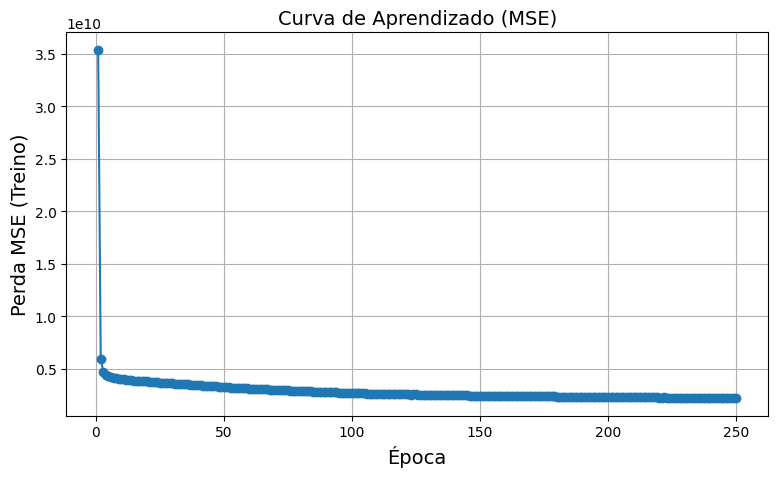

In [59]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-')
plt.xlabel('Época')
plt.ylabel('Perda MSE (Treino)')
plt.title('Curva de Aprendizado (MSE)')
plt.grid(True)
save_fig("pytorch_training_mse_loss_curve")
plt.show()

# Avaliando o Modelo no Conjunto de Teste

In [60]:
print("\n--- Avaliando o modelo no conjunto de teste ---")
model.eval() # Colocar modelo em modo de avaliação
test_loss_mse = 0.0
all_predictions = []
all_labels = []


--- Avaliando o modelo no conjunto de teste ---


In [61]:
with torch.no_grad(): # Desabilitar cálculo de gradientes para avaliação
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)
        test_loss_mse += loss.item() * features.size(0) # Acumular MSE loss
        all_predictions.extend(outputs.cpu().numpy()) # Guardar previsões
        all_labels.extend(labels.cpu().numpy()) # Guardar labels reais

In [62]:
test_loss_mse /= len(test_loader.dataset) # Calcular MSE médio no teste
test_loss_rmse = np.sqrt(test_loss_mse) # Calcular RMSE (raiz quadrada do MSE)

In [63]:
print(f"Perda MSE no Teste: {test_loss_mse:.4f}")
print(f"Perda RMSE no Teste: {test_loss_rmse:.4f}")

Perda MSE no Teste: 2891707454.5116
Perda RMSE no Teste: 53774.5986


## Comparando com o RMSE do Scikit-Learn (mencionado no livro)<br>
O livro menciona RMSEs entre 47000 e 68000 com os modelos Scikit-Learn.<br>
O RMSE que obtive se enquadra nesta faixa.<br>
A escala de `median_house_value` é em dezenas/centenas de milhares, por isso valores tão altos.

Como não escalei os labels, o RMSE calculado (sqrt(MSE)) já está<br>
na escala original em dólares ($).

In [71]:
print(f"\nRMSE no conjunto de teste (escala original $): {test_loss_rmse:.2f}")



RMSE no conjunto de teste (escala original $): 53774.60


Plotando previsões vs valores reais para análise visual

Salvando figura pytorch_predictions_vs_actual


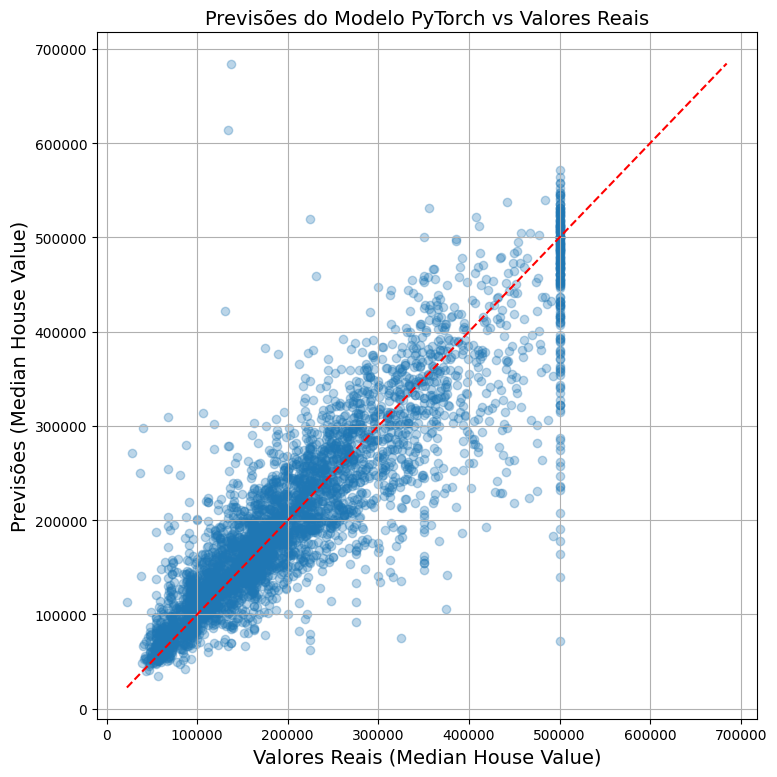

In [65]:
plt.figure(figsize=(8, 8))
plt.scatter(np.array(all_labels), np.array(all_predictions), alpha=0.3)
plt.xlabel("Valores Reais (Median House Value)")
plt.ylabel("Previsões (Median House Value)")
plt.title("Previsões do Modelo PyTorch vs Valores Reais")
# Adicionando a linha y=x como referência
min_val = min(min(all_labels), min(all_predictions))[0]
max_val = max(max(all_labels), max(all_predictions))[0]
plt.plot([min_val, max_val], [min_val, max_val], 'r--')
plt.grid(True)
save_fig("pytorch_predictions_vs_actual")
plt.show()

In [66]:
print("\n--- Fim do script ---")


--- Fim do script ---


Fim do script